In [4]:
from cgeval import Report
from cgeval.report import GenericReport
from cgeval.distribution import Beta, BetaParams
from prettytable import PrettyTable
from decimal import Decimal


import textwrap
import re
from collections import Counter
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import beta
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
from scipy.spatial.distance import jensenshannon


In [75]:
BASE_PATH = f'../../out/pipeline'

MODEL = {
    'Llama-3.3-70B': f'{BASE_PATH}/2025-06-25_sentiment_llama3-3',
    'Llama-2-7B': f'{BASE_PATH}/2025-06-25_sentiment_llama2',
    'Mistral-7B': f'{BASE_PATH}/2025-06-25_sentiment_mistral',
}

IMAGE_MODEL_ANIMAL = {
    'Stable Diffusion 3.5': f'{BASE_PATH}/2025-06-25_animal_detection_stable-diffusion_animal',
    'Stable Cascade': f'{BASE_PATH}/2025-06-25_animal_detection_stable-cascade_animal',
    'FLUX.1-dev': f'{BASE_PATH}/2025-06-25_animal_detection_flux_animal'
}

IMAGE_MODEL_COUNT = {
    'Stable Diffusion 3.5': f'{BASE_PATH}/2025-06-25_animal_detection_stable-diffusion_count',
    'Stable Cascade': f'{BASE_PATH}/2025-06-25_animal_detection_stable-cascade_count',
    'FLUX.1-dev': f'{BASE_PATH}/2025-06-25_animal_detection_flux_count'
}

cls_name2id = {
    'FinancialBERT': 'FIB',
    'lxyuan_DistilBert': 'DSS',
    'ollama3.2': 'LL3',
    'Yolov8': 'VO8',
    'DETR': 'DTR',
    'LLaVA': 'LLV'
}

model_name2id = {
    'Llama-3.3-70B': 'L370B',
    'Llama-2-7B': 'L27B',
    'Mistral-7B': 'Mi7B',
    'Stable Diffusion 3.5': 'SD35',
    'Stable Cascade': 'StCa',
    'FLUX.1-dev': 'FLX1'
}

In [17]:
def load_reports(cfg, base_path):
    reports = []

    for classifier in cfg.classifier:
        report = GenericReport()
        report.load(f"{base_path}/quantify/cls_report_{classifier.id}.json")
        reports.append(report)

    return reports

In [13]:
from prettytable import PrettyTable

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

def fit_beta(samples: np.ndarray[float]) -> BetaParams:
    mu = np.mean(samples)
    var = np.var(samples)

    total_evidence = ((mu * (1. - mu)) / var) - 1.  # a + b

    a = mu * total_evidence
    b = (1. - mu) * total_evidence

    return BetaParams(a=a, b=b)

def get_mode(a,b):
    if a > 1 and b > 1:
        mode = (a - 1) / (a + b - 2)
    else:
        mode = 0 if a < 1 and b >= 1 else 1 
    return mode

def plot_oracle(ax, dist):
    a = dist.params.a
    b = dist.params.b

    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    pdf = beta.pdf(x, a, b)
    line, = ax.plot(x, pdf, color='orange', lw=1, alpha=.8, label='Human')
    ax.fill_between(x, pdf, color=line.get_color(), alpha=0.1)

    mode = get_mode(a, b)
    ax.axvline(mode, color=line.get_color(), linestyle='--', lw=1)


def plot_beta(ax, samples, label):
    dist = fit_beta(samples)

    x = np.linspace(beta.ppf(0.01, dist.a, dist.b), beta.ppf(0.99, dist.a, dist.b), 100)
    pdf = beta.pdf(x, dist.a, dist.b)
    line, = ax.plot(x, pdf, lw=1, alpha=.8, label=label)
    ax.fill_between(x, pdf, color=line.get_color(), alpha=0.1)

    mode = get_mode(dist.a, dist.b)
    ax.axvline(mode, color=line.get_color(), linestyle='--', lw=1)

In [11]:
def get_distributions(cfg, reports):
    distributions = {}

    for idx, cls in enumerate(cfg.classifier):
        report = vars(reports[idx])

        dist = report['dist_report']

        oracle = dist[0]
        p = dist[1]
        p_obs = dist[2]

        oracle_dist = Beta(params=BetaParams(oracle['a'], oracle['b']))
        p_dist = Beta(params=BetaParams(p['a'], p['b']))
        p_obs_dist = Beta(params=BetaParams(p_obs['a'], p_obs['b']))

        distributions[cls.id] = {
            'oracle': oracle_dist,
            'p': p_dist,
            'p_obs': p_obs_dist,
        }

    return distributions

def beta_to_normal_params(alpha, beta_param):
    mu = alpha / (alpha + beta_param)
    var = (alpha * beta_param) / ((alpha + beta_param) ** 2 * (alpha + beta_param + 1))
    sigma = np.sqrt(var)
    return mu, sigma

def js_gauss(mu1, s1, mu2, s2):
    x = np.linspace(0, 1, 1000)
    
    p = norm.pdf(x, mu1, s1)
    q = norm.pdf(x, mu2, s2)

    return jensenshannon(p, q, base=2) 

def js_beta(dist_p, dist_q):
    xs_upper = np.arange(1, 1001) / 1000
    xs_lower = np.arange(0, 1000) / 1000

    p = beta.cdf(xs_upper, dist_p.params.a, dist_p.params.b) - beta.cdf(xs_lower, dist_p.params.a, dist_p.params.b)
    q = beta.cdf(xs_upper, dist_q.params.a, dist_q.params.b) - beta.cdf(xs_lower, dist_q.params.a, dist_q.params.b)

    return jensenshannon(p, q, base=2)


In [ ]:
def plot_binary(ax, reports: list[Report], classifiers, field):
    oracle_dist = vars(reports[0])['dist_report'][0]
    oracle_dist = Beta(params=BetaParams(oracle_dist['a'],oracle_dist['b']))

    plot_oracle(ax, oracle_dist)

    for idx, re in enumerate(reports):
        plot_beta(ax, re.samples[field], f'{classifiers[idx].id}')


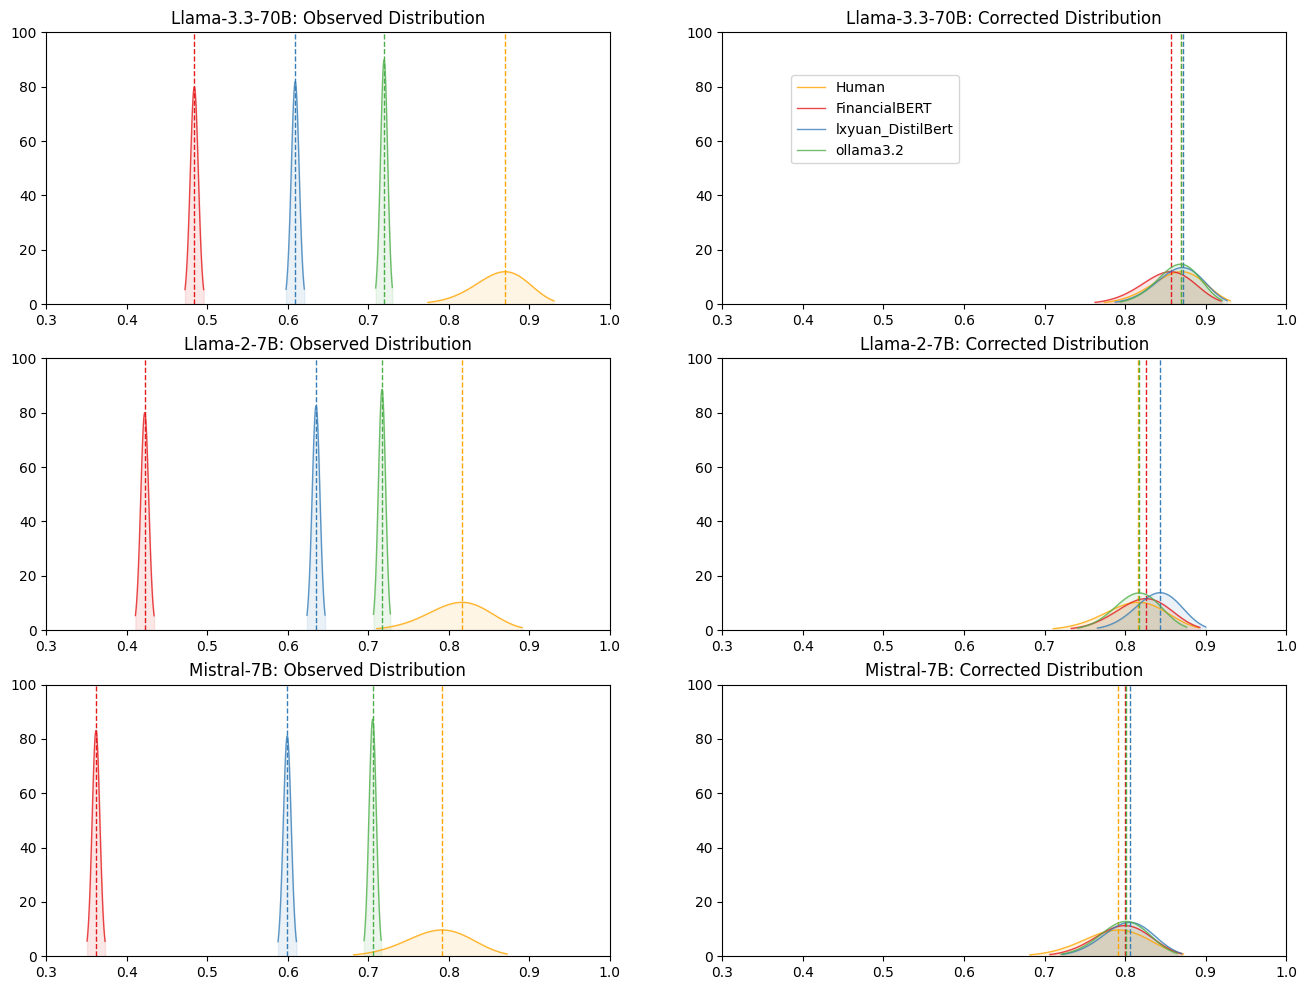

In [ ]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

fig = plt.figure(figsize=(16, 12))

i = 1
for id, path in MODEL.items():
    cfg = OmegaConf.load(f'{path}/config.yaml')

    reports = load_reports(cfg, path)

    ax_1 = fig.add_subplot(3, 2, i)
    ax_1.set_title(f'{id}: Observed Distribution')
    ax_1.set_ylim(0,100)
    ax_1.set_xlim(0.3,1)
    plot_binary(ax_1, reports, cfg.classifier, 'alpha_obs')

    ax_1 = fig.add_subplot(3, 2, i + 1)
    ax_1.set_title(f'{id}: Corrected Distribution')
    ax_1.set_ylim(0,100)
    ax_1.set_xlim(0.3,1)
    plot_binary(ax_1, reports, cfg.classifier, 'alpha')

    i += 2

handles, labels = ax_1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.7, 0.85), ncol=1)

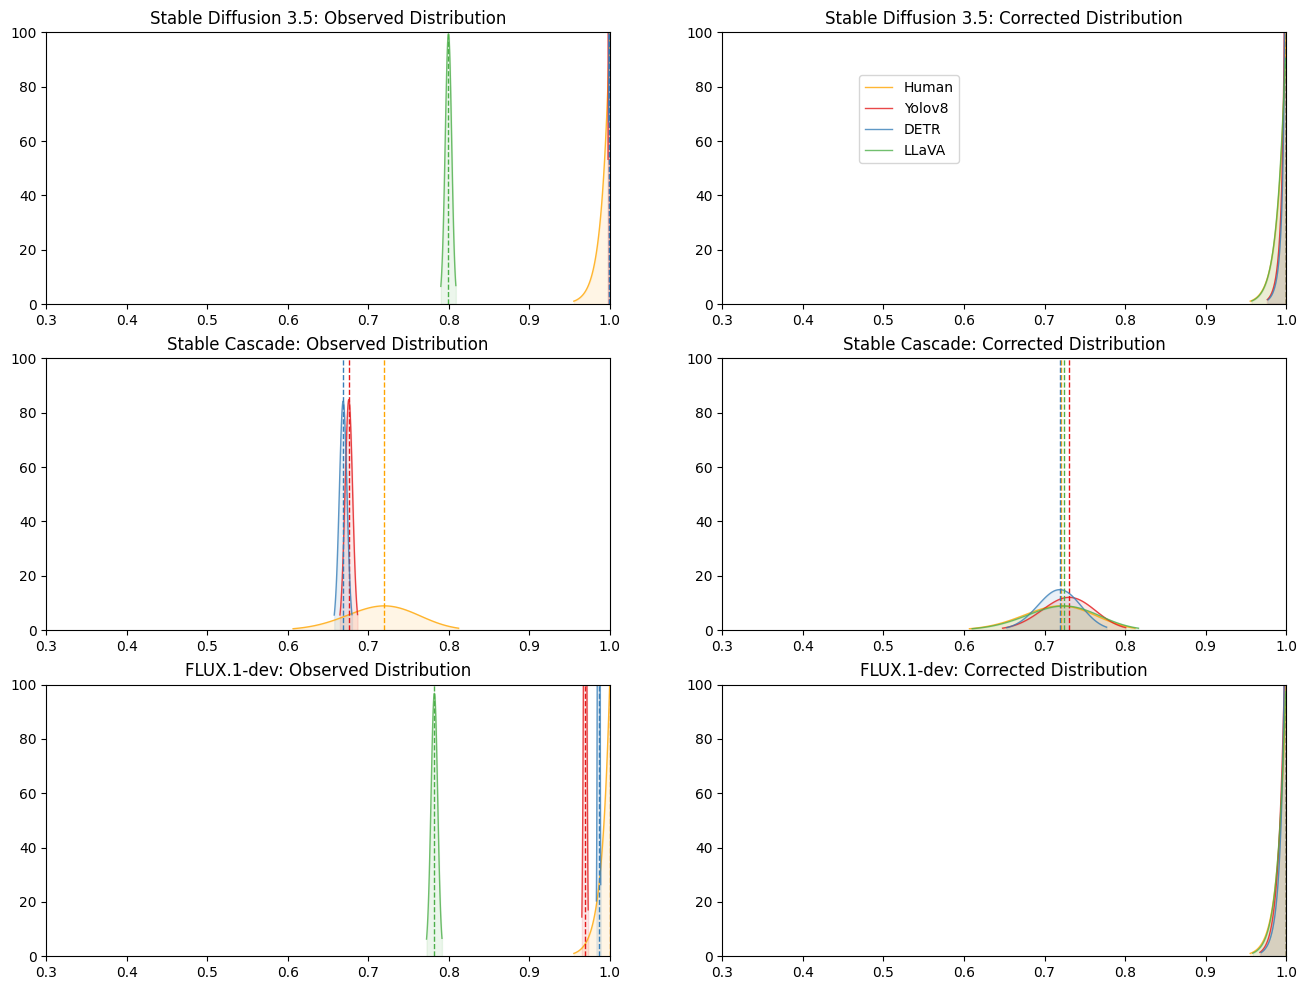

In [83]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

fig = plt.figure(figsize=(16, 12))

i = 1
for id, path in IMAGE_MODEL_ANIMAL.items():
    cfg = OmegaConf.load(f'{path}/config.yaml')

    reports = load_reports(cfg, path)

    ax_1 = fig.add_subplot(3, 2, i)
    ax_1.set_title(f'{id}: Observed Distribution')
    ax_1.set_ylim(0,100)
    ax_1.set_xlim(0.3,1)
    plot_binary(ax_1, reports, cfg.classifier, 'alpha_obs')

    ax_1 = fig.add_subplot(3, 2, i + 1)
    ax_1.set_title(f'{id}: Corrected Distribution')
    ax_1.set_ylim(0,100)
    ax_1.set_xlim(0.3,1)
    plot_binary(ax_1, reports, cfg.classifier, 'alpha')

    i += 2

handles, labels = ax_1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.7, 0.85), ncol=1)

Stable Diffusion 3.5
{'a': 62, 'b': 40, 'classifier': 'oracle', 'kurt': -0.05, 'mean': 0.61, 'skew': -0.09, 'var': 0.00231427}
Stable Cascade
{'a': 6, 'b': 96, 'classifier': 'oracle', 'kurt': 0.74, 'mean': 0.06, 'skew': 0.73, 'var': 0.00053751}
FLUX.1-dev
{'a': 66, 'b': 36, 'classifier': 'oracle', 'kurt': -0.04, 'mean': 0.65, 'skew': -0.12, 'var': 0.00221722}


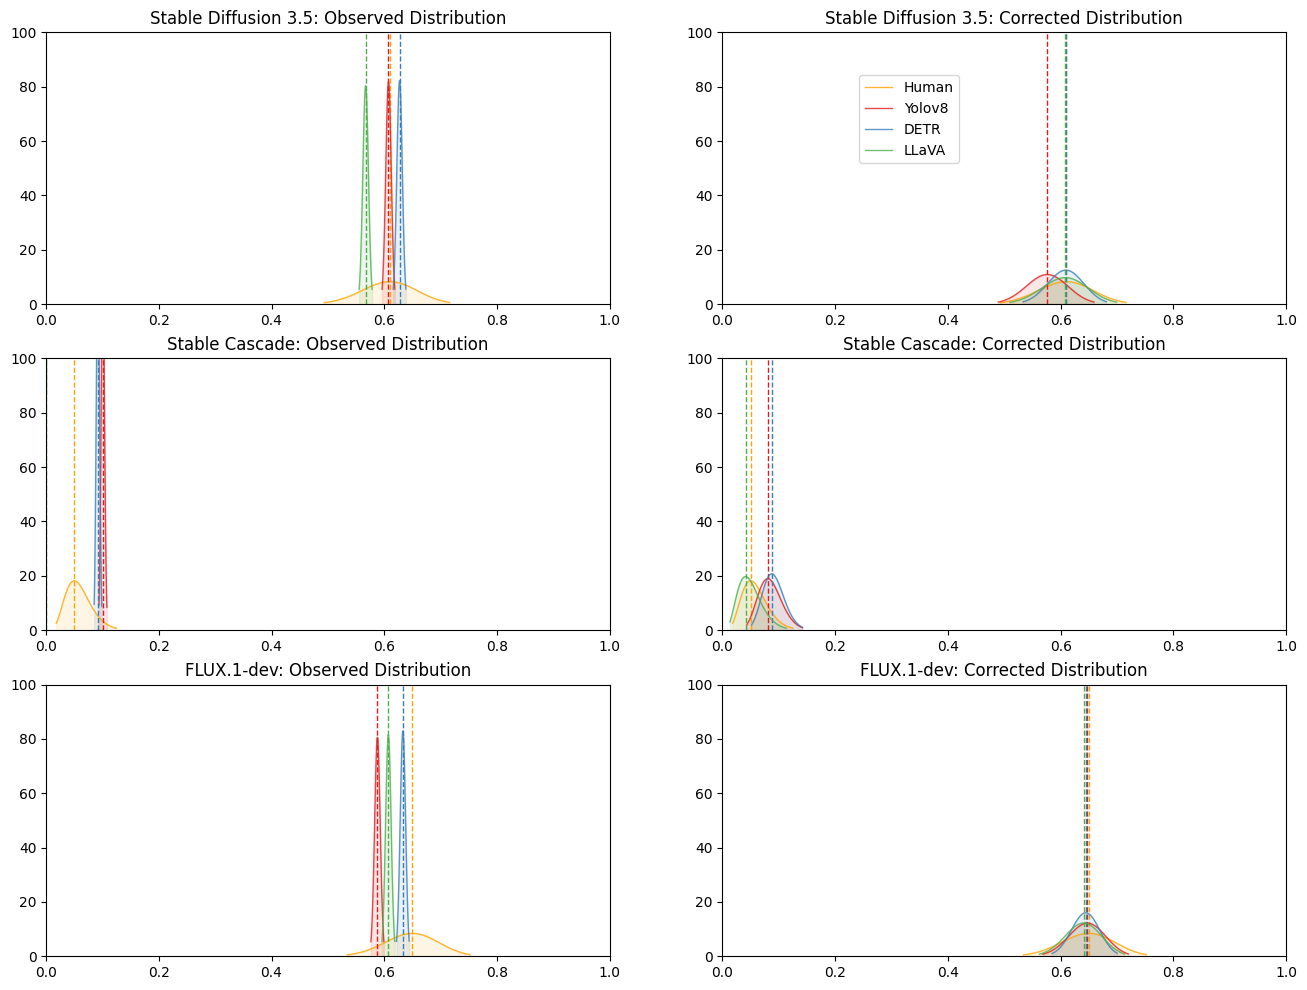

In [84]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

fig = plt.figure(figsize=(16, 12))

i = 1
for id, path in IMAGE_MODEL_COUNT.items():
    print(id)
    cfg = OmegaConf.load(f'{path}/config.yaml')

    reports = load_reports(cfg, path)
    oracle_dist = vars(reports[0])['dist_report'][0]
    print(oracle_dist)

    ax_1 = fig.add_subplot(3, 2, i)
    ax_1.set_title(f'{id}: Observed Distribution')
    ax_1.set_ylim(0,100)
    ax_1.set_xlim(0,1)
    plot_binary(ax_1, reports, cfg.classifier, 'alpha_obs')

    ax_1 = fig.add_subplot(3, 2, i + 1)
    ax_1.set_title(f'{id}: Corrected Distribution')
    ax_1.set_ylim(0,100)
    ax_1.set_xlim(0,1)
    plot_binary(ax_1, reports, cfg.classifier, 'alpha')

    i += 2

handles, labels = ax_1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.7, 0.85), ncol=1)